## Exploratory Data Analysis

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle


#### Read in the ratings and movies tables

In [44]:
base_path = '../Data/'
ratings = pd.read_csv(base_path + 'ratings.csv')
movies = pd.read_csv(base_path + 'movies.csv')
tags = pd.read_csv(base_path + 'tags.csv')
links = pd.read_csv(base_path + 'links.csv')

In [45]:
#fix the size of figures
plt.rcParams["figure.figsize"] = [13, 8]

---

### Tables: Movies & Ratings

In [46]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


##### Movies and corresponding genres are going to be used in principal component analysis(PCA) for clustering, which is what item-based recommendation depended on in this project.

In [47]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


##### Values of rating of a movie given by a user constructs a rating matrix which is going to be factorized(NMF) into two other to build a user-based recommendation system.

---

#### Bare numbers

In [48]:
movies['title'].unique().size
print('The number of unique movie titles is ',movies['title'].unique().size)


The number of unique movie titles is  9737


In [49]:
movies['movieId'].unique().size
print('The number of unique movie ids is ',movies['movieId'].unique().size)


The number of unique movie ids is  9742


In [50]:
ratings['userId'].unique().size
print('The number of unique users is ',ratings['userId'].unique().size)


The number of unique users is  610


### Ratings

#### Averages & Frequencies

In [51]:
ratings['rating'].mean()
print('Average value of rating is',ratings['rating'].mean()
)

Average value of rating is 3.501556983616962


In [52]:
rating_freq = ratings.groupby(['rating'])[['timestamp']].count().sort_values(by= 'timestamp',ascending= False)

In [53]:
rating_freq.columns

Index(['timestamp'], dtype='object')

In [54]:
rating_freq.rename(columns={'timestamp':'frequencies'})

,frequencies
rating,
4.0,26818
3.0,20047
5.0,13211
3.5,13136
4.5,8551
2.0,7551
2.5,5550
1.0,2811
1.5,1791


#### Rating Values Distribution



In [56]:
rating_freq.index

Float64Index([4.0, 3.0, 5.0, 3.5, 4.5, 2.0, 2.5, 1.0, 1.5, 0.5], dtype='float64', name='rating')

In [63]:
type(rating_freq['timestamp']/rating_freq['timestamp'].sum())

pandas.core.series.Series

Text(0, 0.5, 'percentages')

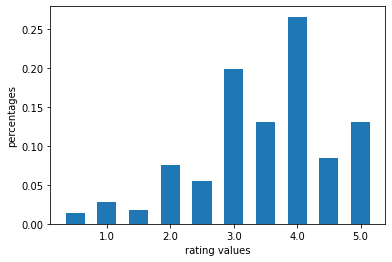

In [74]:
from matplotlib.ticker import StrMethodFormatter

s = rating_freq['timestamp']/rating_freq['timestamp'].sum()
plt.bar(s.index,s.values,width=0.3)

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal places

plt.xlabel('rating values')
plt.ylabel('percentages')

#### The number of ratings *per* user


In [75]:
rating_per_user = ratings.groupby(['userId'])[['rating']].count()

In [76]:
rating_per_user

,rating
userId,
1,232
2,29
3,39
4,216
5,44
...,...
606,1115
607,187
608,831


In [73]:
rating_per_user.describe()

,rating
count,610.000000
mean,165.304918
std,269.480584
min,20.000000
25%,35.000000
50%,70.500000
75%,168.000000
max,2698.000000


#### Users and rating attitudes

In [76]:
rating_per_user[rating_per_user['rating'] >= 20].count()

rating    610
dtype: int64

In [81]:
a = rating_per_user[rating_per_user['rating'] >= 20].count().values[0]
print('The number of users who rated more than 20 movies is', a)

The number of users who rated more than 20 movies is 610


In [83]:
b = rating_per_user[rating_per_user['rating'] >= 200].count().values[0]
print('The number of users who rated more than 200 movies is', b)

The number of users who rated more than 200 movies is 134


In [86]:
n = rating_per_user.max().values[0]
print('The number of movies rated by the user who rated the most is ', n)

The number of movies rated by the user who rated the most is  2698


In [87]:
n = rating_per_user.min().values[0]
print('The number of movies rated by the user who rated the minimum is ', n)

The number of movies rated by the user who rated the minimum is  20


In [89]:
print('The median value of number of rating per user is',rating_per_user.median().values[0])

The median value of number of rating per user is 70.5


<AxesSubplot:ylabel='Count'>

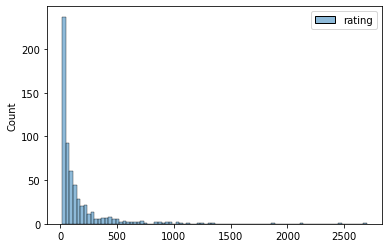

In [90]:
sns.histplot(data = rating_per_user)

###### Most of the users rated minimum amount, then the number of user who rated more decreases as their rating amount increases.

In [92]:
avr_rating_per_user = ratings.groupby(['userId'])[['rating']].mean()

In [93]:
avr_rating_per_user.rename(columns={'rating':'average rating value'})


,average rating value
userId,
1,4.366379
2,3.948276
3,2.435897
4,3.555556
5,3.636364
...,...
606,3.657399
607,3.786096
608,3.134176


In [94]:
#The user who on average rated the worse 
avr_rating_per_user.sort_values(by = 'rating').iloc[[0]]

,rating
userId,
442,1.275


In [95]:
#the user who on average rated the best
avr_rating_per_user.sort_values(by = 'rating').iloc[[-1]]

,rating
userId,
53,5.0


<AxesSubplot:ylabel='Count'>

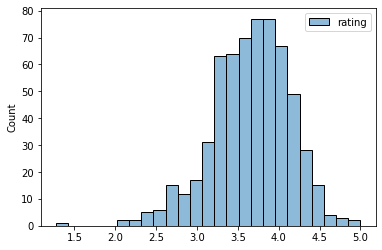

In [97]:
#distribution of average rating values per user
sns.histplot(data = avr_rating_per_user)

### Movies

In [99]:
#get the duplicates in movies
movies.loc[movies['title'].duplicated()]

,movieId,title,genres
5601,26958,Emma (1996),Romance
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [100]:
#get the ones in movies table but not in ratings table
movies.loc[- movies['movieId'].isin(ratings['movieId'])]

,movieId,title,genres
816,1076,"Innocents, The (1961)",Drama|Horror|Thriller
2211,2939,Niagara (1953),Drama|Thriller
2499,3338,For All Mankind (1989),Documentary
2587,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
3118,4194,I Know Where I'm Going! (1945),Drama|Romance|War
4037,5721,"Chosen, The (1981)",Drama
4506,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance
4598,6849,Scrooge (1970),Drama|Fantasy|Musical
4704,7020,Proof (1991),Comedy|Drama|Romance
5020,7792,"Parallax View, The (1974)",Thriller


In [101]:
#get the release year of the movie in a seperate column
movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)')

In [102]:
movies.head()

,movieId,title,genres,release_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [106]:
#split the genres in the genres column
movies['genre_split'] = movies['genres'].str.split(pat="|")

In [107]:
type(movies['genre_split'].explode())

pandas.core.series.Series

In [108]:
#number of movies that are labeled with some number of genres
movies['genre_split'].explode().groupby(level=0).count().value_counts()


2     3218
1     2851
3     2338
4      987
5      271
6       63
7       12
8        1
10       1
Name: genre_split, dtype: int64

In [109]:
#explode one genre out (genres are needed as features for PCA)
movies_explosion = movies.explode('genre_split')

In [110]:
movies_explosion.head(30)

,movieId,title,genres,release_year,genre_split
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Adventure
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Animation
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Children
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Adventure
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Children
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Comedy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Romance


---
### Ratings and movies tables merged

In [111]:
movies.shape,ratings.shape

((9742, 5), (100836, 4))

In [112]:
movies_with_ratings = movies.merge(ratings,how='inner',on='movieId')

#### The number of ratings per movie title

In [113]:
movies_with_ratings.columns

Index(['movieId', 'title', 'genres', 'release_year', 'genre_split', 'userId',
       'rating', 'timestamp'],
      dtype='object')

In [114]:
movies_with_ratings.groupby(['title'])['userId'].nunique().to_frame()

,userId
title,
'71 (2014),1
'Hellboy': The Seeds of Creation (2004),1
'Round Midnight (1986),2
'Salem's Lot (2004),1
'Til There Was You (1997),2
...,...
eXistenZ (1999),22
xXx (2002),24
xXx: State of the Union (2005),5


In [115]:
#Top 10 most rated movies
movies_with_ratings.groupby(['title'])['userId'].nunique().to_frame().sort_values(by='userId',ascending=False).iloc[:10]

,userId
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


In [116]:
movies_avr_rating = movies_with_ratings.groupby(['title'])['rating'].mean().to_frame()

In [117]:
#average rating per movie title
movies_avr_rating

,rating
title,
'71 (2014),4.000000
'Hellboy': The Seeds of Creation (2004),4.000000
'Round Midnight (1986),3.500000
'Salem's Lot (2004),5.000000
'Til There Was You (1997),4.000000
...,...
eXistenZ (1999),3.863636
xXx (2002),2.770833
xXx: State of the Union (2005),2.000000


<AxesSubplot:xlabel='rating', ylabel='Count'>

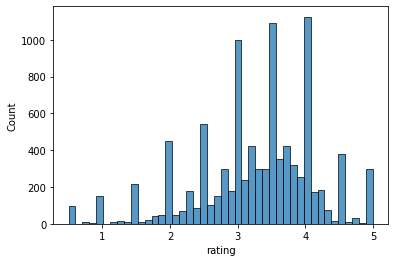

In [118]:
#distribution of average rating per movie
sns.histplot(data = movies_avr_rating, x = 'rating')

In [119]:
#best rated movies by any number of users
movies_avr_rating.sort_values(by='rating',ascending=False).head(10)

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0
"Thin Line Between Love and Hate, A (1996)",5.0
Lesson Faust (1994),5.0
Eva (2011),5.0
Who Killed Chea Vichea? (2010),5.0


In [121]:
movies_rating_count = movies_with_ratings.groupby(['title'])['rating'].count().to_frame()

In [122]:
filter = movies_with_ratings['title'].isin(movies_rating_count.loc[movies_rating_count['rating'] >=30].index)

In [123]:
#best rated movies by minimum 30 of users
movies_with_ratings.loc[filter].groupby(['title'])['rating'].mean().to_frame().sort_values(by='rating',ascending=False).head(10)

,rating
title,
"Shawshank Redemption, The (1994)",4.429022
Lawrence of Arabia (1962),4.300000
"Godfather, The (1972)",4.289062
Fight Club (1999),4.272936
Cool Hand Luke (1967),4.271930
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041
Rear Window (1954),4.261905
"Godfather: Part II, The (1974)",4.259690
"Departed, The (2006)",4.252336
